In [25]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving pac

In [2]:
Pkg.add("ProgressMeter")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`


In [26]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = IonSim.modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];
print(L)

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0imλ: 7.291469963176486e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 0.0 ⋅ 2π


In [27]:
function pulse(T:: Chamber , tspan, pitime, del_intensity)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime/2

    res_intensity = intensity_from_pitime(L, pi2_time, T.iontrap.ions[1], ("g", "e"), T)
    actual_intensity = res_intensity + del_intensity

    intensity!(L, (actual_intensity))


    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time, del_intensity)
    pitime = 4e-6
    tspan = 0: 0.1: (wait_time)

    h = pulse(T, tspan, pitime, del_intensity)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [28]:
function detuning_intensity1(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    if(t_wait == 1)
    plot(x, real.(excited_pop1))
    println(real.(excited_pop1[end]))
    println(x)
    end
    return x, real.(excited_pop1[end])

end

detuning_intensity1 (generic function with 1 method)

0.5410672165308773
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5410672165308773
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.536170768846579
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.0772379853774563
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5811929087413067
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.658430894118763
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5166634771069478
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.175094371225711
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5077704590380175
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.682864830263729
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.533342346105854
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3.2162071763695828
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5367488653584123
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3.752956041727995
[0.0, 0.1, 0

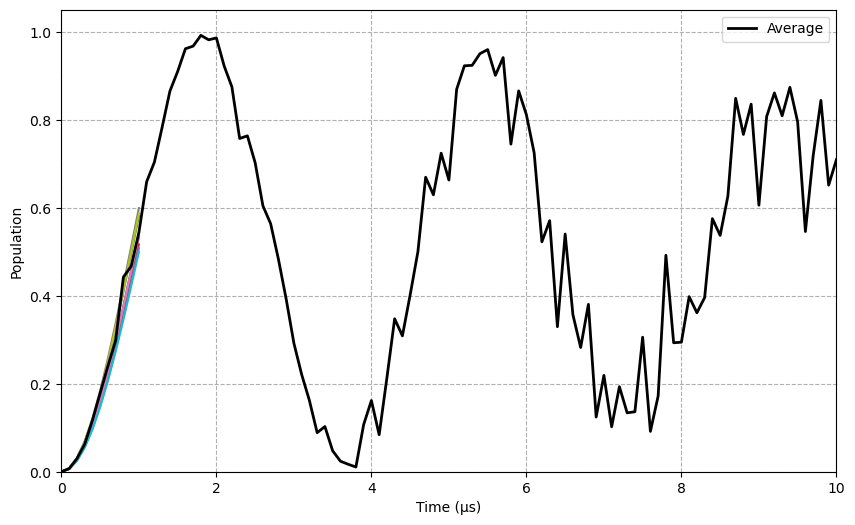

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [29]:

figure(figsize=(10, 6))
I_rms_1 = 10
noise_distribution_1 = Normal(0, I_rms_1)
tout, ind = detuning_intensity1(L, 10*1e6, 1, 10)
# println(tout)
# println( ind)
sumB=0.0
ind = []
push!(ind, 0)
for j in 0.1:0.1:10
    sumB=0.0
    for i in 1:1:10
        δB_shot = rand(noise_distribution_1)
        tout1, indi = detuning_intensity1(L, abs(δB_shot*1e5), i, j)
        sumB= sumB + (indi)
        if(j == 1)
        println(sumB)
        println(tout1)
    end
    end
   
    push!(ind, sumB/10)
    
end
println(ind)
plot(tout, ind , label="Average", color = "black", linewidth=2)

xlim(0, 10)
xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [30]:
function detuning_intensity2(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    
    return x[end], real.(excited_pop1[end])

end

detuning_intensity2 (generic function with 1 method)

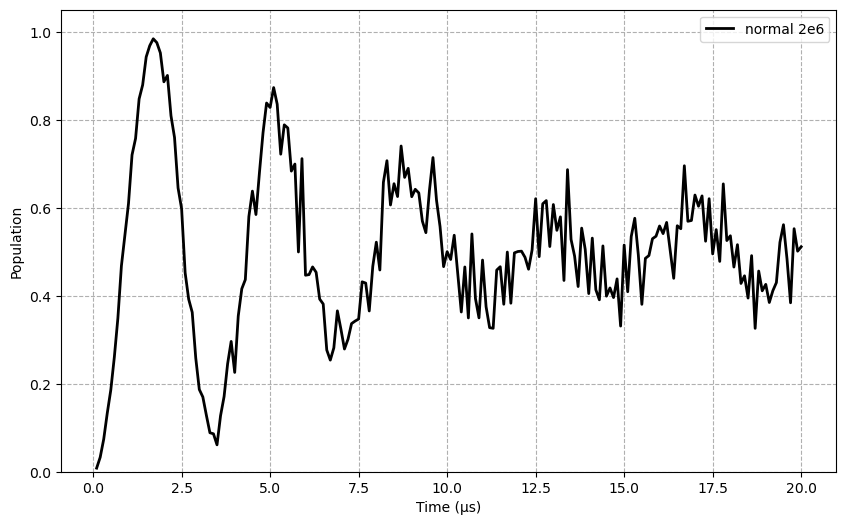

Any[0.00818622972029939, 0.03268389531374115, 0.07387184666555334, 0.13286744735596243, 0.18578944781797133, 0.2604025435247465, 0.34889867474901115, 0.4678950804885134, 0.5394311395315617, 0.6093846407165106, 0.720021626743896, 0.7574714245422732, 0.8473081441983628, 0.8790063777349478, 0.9427307984013018, 0.9682341047118069, 0.9839377284040116, 0.9751822767180225, 0.9518550192065388, 0.8861872889357941, 0.9006414384960549, 0.8090711661001504, 0.7596867518610141, 0.6450021007949208, 0.5977573429960296, 0.45218334640298624, 0.3921026230572011, 0.36223570107166514, 0.2581934192575155, 0.1869289277966839, 0.16987292065998943, 0.12824995319724847, 0.0885478942656826, 0.0861518883958154, 0.061113643094223416, 0.12728964159150263, 0.17086659205105825, 0.24544261995086605, 0.29611376983892335, 0.22570095874958565, 0.3537992795221957, 0.41578909899379, 0.4365829212855901, 0.5799338991416116, 0.6377292037163115, 0.5845281879719794, 0.6810082435310224, 0.7704801572825534, 0.8379877844287711, 0.

In [31]:

figure(figsize=(10, 6))
I_rms_1 = 2e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="normal 2e6", color = "black", linewidth=2)

xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

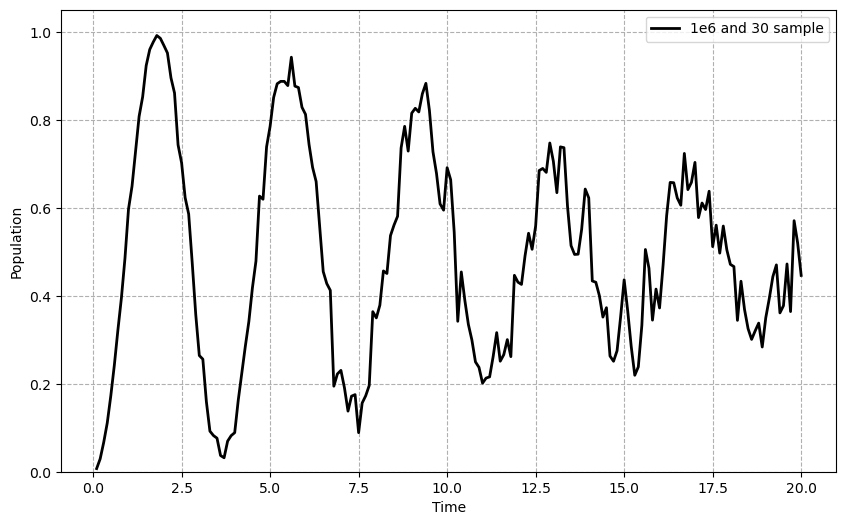

Any[0.007096695820537114, 0.029297505669782807, 0.06669732825804583, 0.11086402162457115, 0.17236753984352685, 0.24206118068653024, 0.3214151586563776, 0.3950699525552952, 0.48472081232783154, 0.5967650451745432, 0.6490469183018758, 0.7277459343786739, 0.807728229389904, 0.8520376784957008, 0.9230575712436975, 0.9595741622380692, 0.9766511597376637, 0.9913706958765168, 0.9849702115744755, 0.9686737666701678, 0.9516299478911744, 0.8950721954230018, 0.8607274471719056, 0.742890937563121, 0.7019497669185157, 0.6228777533074692, 0.5855678048318652, 0.47479695217699175, 0.3569364675052032, 0.2640778762282259, 0.25579309314884485, 0.15913226465759425, 0.09216559416841626, 0.082211208895417, 0.07625828307461613, 0.036818966580281325, 0.03170474678228998, 0.06953333092579538, 0.08200259969130011, 0.08878155006963799, 0.16251400248690917, 0.22331914729502234, 0.2851033150353129, 0.3414821621639641, 0.41778427487599035, 0.47854660900990814, 0.6264373518200194, 0.6192704469100856, 0.7382909544821

In [32]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="1e6 and 30 sample", color = "black", linewidth=2)

xlabel("Time")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

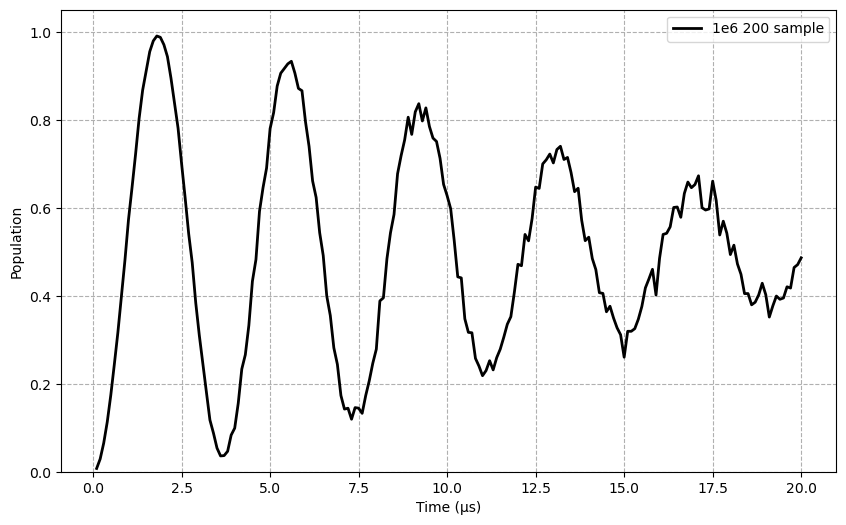

Any[0.007403654014526422, 0.02901903335390788, 0.06503490452170578, 0.11311383038423971, 0.1741226812903768, 0.24402392147145358, 0.3163415644612353, 0.3978637657852854, 0.4809662160656137, 0.5729183872726787, 0.6458437236613825, 0.7217027132188815, 0.8029157119132779, 0.8673081789536146, 0.9116829175337853, 0.9547089168936179, 0.979097436676017, 0.9902827076630161, 0.9873018380831923, 0.9705033537896288, 0.943350017143943, 0.894443656389507, 0.8372642989155404, 0.7809479968346106, 0.7000024476479224, 0.6226300037630462, 0.5408866733056519, 0.47518723610143765, 0.38346039918830954, 0.3100913666620501, 0.24506699622051914, 0.1813123434466678, 0.117527157523574, 0.08772827882379937, 0.053759584680143656, 0.03591569037324674, 0.036615519211449545, 0.04641459197658354, 0.08326229045327543, 0.09906336505315477, 0.15568201532616874, 0.2332903283316879, 0.26591972295028726, 0.33286214503653566, 0.4329498026081836, 0.48220866101813414, 0.5916864407169035, 0.6455873357690113, 0.6900534457982507

In [33]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:200
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/200)
end
println(ind)
plot(tout2, ind , label="1e6 200 sample", color = "black", linewidth=2)

xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

In [11]:
    using Pkg
    Pkg.add("GLM")
    Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...
   Installed DataValueInterfaces ─ v1.0.0
   Installed TableTraits ───────── v1.0.1
   Installed StatsModels ───────── v0.7.7
   Installed ShiftedArrays ─────── v2.0.0
   Installed GLM ───────────────── v1.9.0
   Installed Tables ────────────── v1.12.1
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [38e38edf] + GLM v1.9.0
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
  [e2d170a0] + DataValueInterfaces v1.0.0
  [38e38edf] + GLM v1.9.0
  [1277b4bf] + ShiftedArrays v2.0.0
  [3eaba693] + StatsModels v0.7.7
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Tables v1.12.1
Precompiling packages...
    661.7 ms  ✓ DataValueInterfaces
    539.5 ms  ✓ TableTraits
    621.3 ms  ✓ ShiftedArrays
   4554.3 ms  ✓ Tables
   2171.8 ms  ✓ StructUtils → StructUtilsTablesExt
   2178.1 ms  ✓ RecursiveArrayTools → RecursiveArrayToolsTablesExt
   4396.4 ms  ✓ StatsModels
   2678.7 ms  ✓ GLM
  8 dependencies successfully precompil

In [12]:
using Pkg
Pkg.add("LsqFit")

   Resolving package versions...
   Installed LsqFit ─ v0.15.1
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [2fda8390] + LsqFit v0.15.1
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
  [2fda8390] + LsqFit v0.15.1
Precompiling packages...
   2306.4 ms  ✓ LsqFit
  1 dependency successfully precompiled in 3 seconds. 455 already precompiled.


In [13]:
using LsqFit

# Define the complex model C(t)
# p[1] corresponds to ω₀ (omega_0)
# p[2] corresponds to σ (sigma)
function model_complex(t, p) 
    return exp.(im * p[1] * t) .* exp.(-0.5 * p[2]^2 * t.^2)
end

# Create a wrapper for LsqFit.jl
# This model takes a vector of time points 't' and parameters 'p',
# and returns a real-valued vector where real and imaginary parts are interleaved.
function model_real_interleaved(t, p)
    complex_output = model_complex(t, p)
    # Create a vector to hold interleaved real and imaginary parts
    # It will have twice the length of the input 't' vector
    output = zeros(length(t))
    output[1:1:end] = real(complex_output) # Assign real parts to odd indices
    #output[2:2:end] = imag(complex_output) # Assign imaginary parts to even indices
    return output
end

model_real_interleaved (generic function with 1 method)

In [14]:
# --- 1. Generate Synthetic Data ---

# True parameters we want to recover
p_true = [
    2.5,  # ω₀
    0.8   # σ
]

# Time points
t_data = 0:0.1:10

# Generate the "perfect" complex data using the true parameters
y_complex_perfect = model_complex(t_data, p_true)

# Add some complex Gaussian noise
noise_real = 0.05 * randn(length(t_data))
noise_imag = 0.05 * randn(length(t_data))
y_complex_noisy = y_complex_perfect + (noise_real + im * noise_imag)

# Prepare the noisy data for fitting by interleaving its real and imaginary parts
y_real_interleaved = zeros(2 * length(t_data))
y_real_interleaved[1:2:end] = real(y_complex_noisy)
y_real_interleaved[2:2:end] = imag(y_complex_noisy)


# --- 2. Perform the Fit ---

# Initial guess for the parameters [ω₀, σ]
p0 = [2.0, 1.0]

# Use curve_fit to find the best parameters
fit = curve_fit(model_real_interleaved, tout2, ind, p0)

# The fitted parameters are in fit.param
p_fit = fit.param
println("True parameters: ", p_true)
println("Fitted parameters: ", p_fit)


# --- 3. Visualize the Results ---

# Generate the fitted curve using the complex model
y_fit = model_complex(tout2, p_fit)

# Plot the real parts
#plot(t_data, real(y_complex_noisy), seriestype=:scatter, label="Noisy Data (Real)", legend=:topright)
plot(tout2, real(y_fit), linewidth=3, label="Fitted Model (Real)")

# Plot the imaginary parts
# plot!(t_data, imag(y_complex_noisy), seriestype=:scatter, label="Noisy Data (Imag)")
# plot!(tout2, imag(y_fit), linewidth=3, label="Fitted Model (Imag)")

# title!("Fitting a Complex Decoherence Model")
# xlabel!("Time (t)")
# ylabel!("C(t)")
display(gcf())

MethodError: MethodError: no method matching zero(::Type{Any})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T
   @ Base missing.jl:105
  zero(!Matched::Type{Union{}}, Any...)
   @ Base number.jl:315
  zero(!Matched::Type{Dates.Date})
   @ Dates C:\Users\jewoo\.julia\juliaup\julia-1.12.3+0.x64.w64.mingw32\share\julia\stdlib\v1.12\Dates\src\types.jl:459
  ...


In [15]:
using LsqFit

# p[1] = ω₀
# p[2] = σ
function complex_model(t, p)
    ω₀ = p[1]
    σ = p[2]
    
    # Use broadcasting (.@) to apply the function to each element of t
    return @. exp(im * ω₀ * t) * exp(-0.5 * σ^2 * t^2)
end

complex_model (generic function with 1 method)

In [16]:
# This is the function we will pass to curve_fit
function fit_model(t, p)
    # Get the complex predictions
    predictions_complex = complex_model(t, p)
    
    # Stack the real and imaginary parts into one long vector
    return [real(predictions_complex); imag(predictions_complex)]
end

fit_model (generic function with 1 method)

In [17]:
using LsqFit
using Random # for noise

# --- 1. Define Models ---

# p[1] = ω₀
# p[2] = σ
function complex_model(t, p)
    return @. exp(im * p[1] * t) * exp(-0.5 * p[2]^2 * t^2)
end

function fit_model(t, p)
    predictions_complex = complex_model(t, p)
    return [real(predictions_complex); imag(predictions_complex)]
end

# --- 2. Generate Sample Data ---
true_params = [
    10.0,  # ω₀
    0.5    # σ
]

t_data = 0:0.1:10.0
C_data_clean = complex_model(t_data, true_params)

# Add some complex noise
Random.seed!(123)
noise_real = 0.05 .* randn(length(t_data))
noise_imag = 0.05 .* randn(length(t_data))
C_data_noisy = C_data_clean .+ (noise_real .+ im .* noise_imag)

# --- 3. Prepare Data for Fitting ---
# Create the stacked y-vector that matches our fit_model's output
y_data_stacked = [real(C_data_noisy); imag(C_data_noisy)]

# --- 4. Run the Fit ---
# Initial guess for parameters p = [ω₀, σ]
p_guess = [9.0, 0.8]

# Run the curve_fit function
# We pass t_data as the x-data and the stacked vector as the y-data
fit_result = curve_fit(fit_model, t_data, y_data_stacked, p_guess)

# --- 5. View Results ---
println("Fit converged: ", fit_result.converged)
println("Fitted Parameters: ", coef(fit_result))
println("True Parameters:   ", true_params)

plot()
# You can get R-squared, residuals, etc. from the fit_result object
# Note: The residuals will be for the *stacked* vector
# println("\nR-squared: ", r2(fit_result))

Fit converged: true
Fitted Parameters: [10.012823490801303, 0.49324021721642153]
True Parameters:   [10.0, 0.5]


Any[]

In [18]:
using LsqFit

# 1. Define your analytic model (from our last conversation)
# p[1] = ω₀
# p[2] = σ
@. real_model(t, p) = cos(p[1] * t) * exp(-0.5 * p[2]^2 * t^2)

# --- ASSUME YOUR DATA IS LOADED ---
# ind = [...]    # Your x-values (time)
# tout2 = [...]  # Your y-values (the real part of C(t))
# ---------------------------------

# 2. Make an initial guess for the parameters [ω₀, σ]
# !! This is the most important part. You must provide a guess.
# Try to guess ω₀ by looking at the frequency of your data.
# Guess σ to be a small positive number.
p_guess = [1.0, 0.5]  # <--- YOU WILL LIKELY NEED TO CHANGE THIS

# 3. Run the fit
fit = curve_fit(real_model, tout2, ind, p_guess)

# 4. Get the best-fit parameters
fit_params = coef(fit)

println("Fit converged: ", fit.converged)
println("Fitted ω₀: ", fit_params[1])
println("Fitted σ:  ", fit_params[2])

MethodError: MethodError: no method matching zero(::Type{Any})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T
   @ Base missing.jl:105
  zero(!Matched::Type{Union{}}, Any...)
   @ Base number.jl:315
  zero(!Matched::Type{Dates.Date})
   @ Dates C:\Users\jewoo\.julia\juliaup\julia-1.12.3+0.x64.w64.mingw32\share\julia\stdlib\v1.12\Dates\src\types.jl:459
  ...


In [19]:
# 5. Generate a smooth line for the fitted model
# Create a dense range of x-values from the start to end of your data
t_fit = range(minimum(tout2), maximum(tout2), length=200)

# Calculate the y-values using your *fitted* parameters
y_fit = real_model(t_fit, fit_params)

# 6. Plot everything
plot(
    tout2, 
    ind, 
    
)

plot(
    t_fit, 
    y_fit, 
    
    linewidth=3, 
    color=:red, 
    label="Fitted Model"
)

display(gcf())

ArgumentError: ArgumentError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

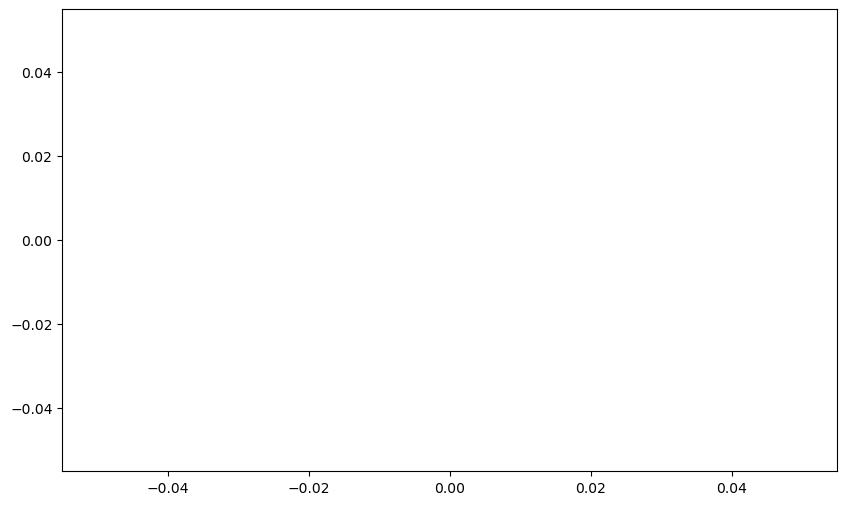

In [20]:
df = DataFrame(x = tout2)
df.y = ind  
PyPlot.scatter(df.x, df.y, label="data")
display(gcf())

In [21]:
Pkg.add("GLM")
Pkg.add("Statistics")
Pkg.add("StatsBase")

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [10745b16] + Statistics v1.11.1
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [2913bbd2] + StatsBase v0.34.9
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`


In [22]:

figure(figsize=(10, 6))
plot(df.x, df.y, label="data")
f(x, p) = 1/2 .* (1 .- cos.(p[1] .* x) .* exp.(-p[2] .* x.^2))

# initial guess for [a, b]
p0 = [1, 1.0]

# fit the model to your data
fit = curve_fit(f, df.x, df.y, p0)

println("a1 = ", fit.param[1])
println("a2 = ", fit.param[2])
#println("\nR-squared: ", r2(fit))
# plot data vs fitted curve
plot(df.x, f(df.x, fit.param), label="fit")





display(gcf())


MethodError: MethodError: no method matching zero(::Type{Any})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T
   @ Base missing.jl:105
  zero(!Matched::Type{Union{}}, Any...)
   @ Base number.jl:315
  zero(!Matched::Type{Dates.Date})
   @ Dates C:\Users\jewoo\.julia\juliaup\julia-1.12.3+0.x64.w64.mingw32\share\julia\stdlib\v1.12\Dates\src\types.jl:459
  ...


In [23]:
 residuals = fit.resid

 println(residuals)
    # Calculate the sum of squares of residuals (SSR)
    SSR = sum(abs2, residuals)

    # Calculate the total sum of squares (SST)
    # You need the mean of the original ydata for this
    mean_y = mean(tout2)
    SST = sum(abs2, tout2 .- mean_y)

    # Calculate R-squared
    R2 = 1 - (SSR / SST)

    println("R-squared: $R2")

UndefVarError: UndefVarError: `fit` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.
Hint: a global variable of this name also exists in StatsAPI.
    - Also exported by StatsBase (loaded but not imported in Main).
    - Also exported by Distributions.